In [1]:
%matplotlib notebook
%autosave 0
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import numpy as np
from numpy.random import RandomState
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import animation
#from os.path import join
#import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
import pickle
#from sklearn import svm, datasets
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix, classification_report, balanced_accuracy_score
from tqdm.notebook import tqdm

Autosave disabled


In [2]:
import sys
sys.path.append("../imbalanced_dataset_sampler/torchsampler/")
sys.path.append("../libs")
from vvv_utils import parse_metadata, parse_light_curve_data, plot_light_curve, get_train_test_ids
from imbalanced import ImbalancedDatasetSampler


### Parse Metadata

In [3]:
df_meta = parse_metadata(experiment="ALL", merge_subclasses=True)
class_names = df_meta["label"].unique()


88454 light curve metadata collected


In [4]:
display(df_meta.head(5))

,P1,P2,P_ogle,label
ID_VVV,,,,
b221_201_22183,13.972335,6.986167,13.970992,binary
b221_205_41463,21.537799,10.770059,21.541892,binary
b232_614_24529,8.035356,16.069420,16.065114,binary
b233_201_30278,8.750438,4.374645,8.751487,binary
b233_201_16631,44.130627,22.070183,44.161985,binary


In [29]:
df_meta['P_ogle'].loc[df_meta["label"] == "cepheid"]

ID_VVV
D04               15.65736
D05                9.97828
D06               21.23539
D07               18.53538
D08               10.67261
                    ...   
b325_511_41558    12.06131
b326_209_87767     9.48413
b326_310_2687      9.48413
b326_414_12058     6.53859
b326_316_59841     9.59195
Name: P_ogle, Length: 1494, dtype: float64

<IPython.core.display.Javascript object>


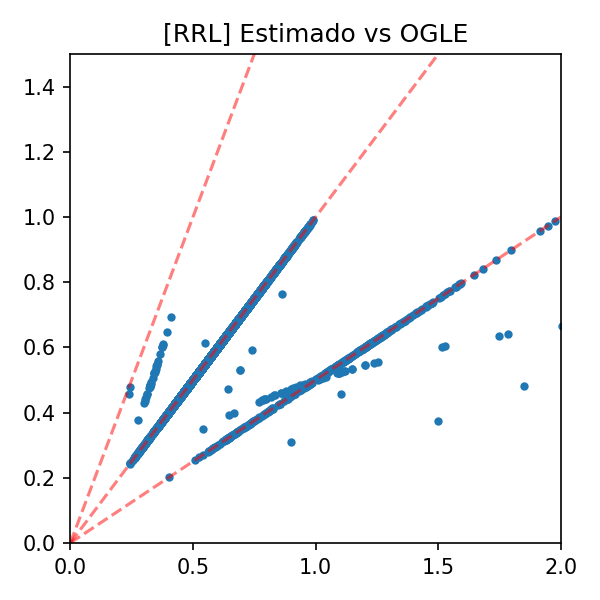

0.3263153242084481


In [32]:
fig, ax =plt.subplots(1,1,figsize=(4,4),tight_layout=True)
x = np.linspace(0, 2)
ax.plot(x, x,'r--',alpha=0.5)
ax.plot(x, x/2,'r--',alpha=0.5)
ax.plot(x, x*2,'r--',alpha=0.5)
ax.scatter(df_meta['P1'].loc[df_meta["label"] == "rrlyrae"],df_meta['P_ogle'].loc[df_meta["label"] == "rrlyrae"],marker='.')
ax.set_title('[RRL] Estimado vs OGLE')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5])
error = sum(np.abs(df_meta['P_ogle'].loc[df_meta["label"] == "binary"] - df_meta['P1'].loc[df_meta["label"] == "binary"])/df_meta['P_ogle'].loc[df_meta["label"] == "binary"] < 0.1)/67873
print(error)
#ax[1].scatter(df_meta['P2'],df_meta['P_ogle'],marker='.')
#ax[1].set_title('P2 vs OGLE')

#ax[2].scatter(df_meta['P1'],df_meta['P_ogle'])

In [27]:
46380+42074
0.326 Bin
0.974 rrl
0.891 cef

88454

In [29]:
"""
indices_vvv = np.arange(len(df_meta))
#indices_vvv


df_meta["idx"] = indices_vvv
df_meta = df_meta.reset_index()
#df_meta


#df_meta = df_meta[["idx","ID_VVV","P1","P2","P_ogle","label"]]
df_meta = df_meta.set_index(df_meta["idx"])
df_meta.drop(labels="idx",axis=1,inplace=True)
#df_meta
"""

### Definiciones de Clases, Variables, Datasets

In [23]:
lc_classes = {"label":{"binary":0, "rrlyrae":1, "cepheid":2}}

In [24]:
# Variable Categórica, reemplaza nombres por números
df_meta.replace(lc_classes,inplace=True)
#df_meta

In [3]:
# NUEVO

class LightCurve_Dataset(Dataset):
    def __init__(self, df_metadata, transform=None):        
        self.data = list()
        self.name = df_metadata.index.values
        self.period = df_metadata["P_ogle"]
        self.label = df_metadata["label"].values
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
        
        for i in range(len(df_metadata)):
            lc_data = parse_light_curve_data(self.name[i])
            lc_data["phase"] = np.mod(lc_data["mjd"],self.period[i])/self.period[i]
            #display(lc_data)
            #normalize
            mag_std = lc_data["mag"].std()
            lc_data["mjd"] = lc_data["mjd"]-lc_data["mjd"].min()
            lc_data["mag"] = (lc_data["mag"]-lc_data["mag"].mean())/mag_std
            lc_data["err"] = lc_data["err"]/mag_std
            lc_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            """if len(lc_data) == 335:
                lc_data["mask"] = 1
            else:
                while len(lc_data) < 335:
                    #RELLENAR con 0s;
                    lc_data = lc_data.append(df_zeros, ignore_index=True,sort=False)
            lc_data = lc_data.fillna(1)
            lc_data = lc_data[["phase","mag","err","mjd","mask"]]
            self.data.append(torch.from_numpy(lc_data.values.astype('float32')))
            """
            lc_data = lc_data[["phase","mag","err","mjd"]]
            lc_data_large = np.zeros(shape=(335, 5), dtype='float32')
            lc_data_large[:lc_data.shape[0], :4] = lc_data.values
            lc_data_large[:lc_data.shape[0], 4] = 1.
            self.data.append(torch.from_numpy(lc_data_large))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label_to_num(self.label[idx]),'name': self.name[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    def label_to_num(self, label):
        if label=='binary':
            return 0
        elif label=='rrlyrae':
            return 1
        else:
            return 2
        
    def period(self,idx):
        return self.period[idx]

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

In [66]:
# SIN NORMALIZAR, SIN RELLENAR CON 0s

class LightCurve_Dataset2(Dataset):
    def __init__(self, df_metadata, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["P_ogle"]
        self.label = df_metadata["label"].values
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
        
        for i in range(len(df_metadata)):
            lc_data = parse_light_curve_data(self.name[i])
            lc_data["phase"] = np.mod(lc_data["mjd"],self.period[i])/self.period[i]
            #display(lc_data)
            """
            #normalize
            mag_std = lc_data["mag"].std()
            lc_data["mjd"] = lc_data["mjd"]-lc_data["mjd"].min()
            lc_data["mag"] = (lc_data["mag"]-lc_data["mag"].mean())/mag_std
            lc_data["err"] = lc_data["err"]/mag_std
            lc_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            if len(lc_data) == 335:
                lc_data["mask"] = 1
            else:
                while len(lc_data) < 335:
                    #RELLENAR con 0s;
                    lc_data = lc_data.append(df_zeros, ignore_index=True,sort=False)
            lc_data = lc_data.fillna(1)
            lc_data = lc_data[["phase","mag","err","mjd","mask"]]
            self.data.append(torch.from_numpy(lc_data.values.astype('float32')))
            """
            lc_data = lc_data[["phase","mag","err","mjd"]]
            #lc_data_large = np.zeros(shape=(335, 5), dtype='float32')
            #lc_data_large[:lc_data.shape[0], :4] = lc_data.values
            #lc_data_large[:lc_data.shape[0], 4] = 1.
            self.data.append(torch.from_numpy(lc_data.values))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample
    def period(self,idx):
        return self.period[idx]

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

**Dataset**

Vista Variables in the Via lactea

In [11]:
#%%timeit -n 1 -r 1   --->  aprox 26:55 mins on Frank
VVV = LightCurve_Dataset(df_meta)

In [9]:
VVV_test = LightCurve_Dataset(df_meta.loc[test_idx])

In [10]:
VVV_test[0]

{'data': tensor([[7.3007e-03, 2.5800e+00, 3.5793e-01, 6.7708e+02, 1.0000e+00],
         [9.4018e-03, 1.3905e+00, 6.0336e-01, 7.0484e+02, 1.0000e+00],
         [5.5534e-02, 2.8841e+00, 5.9037e-01, 6.8404e+02, 1.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]),
 'label': 0,
 'name': 'b292_402_83438'}

In [106]:
                                                                                                                                                                                                                                                                         VVV_subtest = torch.utils.data.Subset(VVV_test,list(diff_A))

In [18]:
test_loader = DataLoader(VVV_test, batch_size=512,shuffle=False)

In [107]:
#test_sampler = SubsetRandomSampler(indices=list(diff_A))
test_loader_dif = DataLoader(VVV_subtest, batch_size=512,sampler=None,shuffle=False)

In [21]:
N_model,m_type,s='4','A',1
path_ = make_path(N_model,s)
modelo = load_besto_model(path_,m_type)

y_t, y_p = evaluate_model(modelo, test_loader,m_type)

In [81]:
N_model,m_type,s='4','A',1
path_ = make_path(N_model,s)
modelo = load_besto_model(path_,m_type)

y_t, y_p = evaluate_model(modelo, test_loader,m_type)

In [22]:
cm = confusion_matrix(y_t,y_p)
cm

array([[6720,   65,    5],
       [  27, 1805,   77],
       [   1,   30,  118]])

In [91]:
df_meta.loc[test_idx].index.values

array(['b292_402_83438', 'b381_112_23559', 'b276_211_91437', ...,
       'b283_211_27467', 'b362_106_54099', 'b387_602_1121'], dtype=object)

In [23]:
rrl_TP_CNN = set(df_meta.loc[test_idx].index.values[(y_t==1)&(y_p==1)])

In [24]:
rrl_FP_CNN = set(df_meta.loc[test_idx].index.values[(y_t!=1)&(y_p==1)])

In [27]:
rrl_test = set(df_meta.loc[test_idx].index.values[(y_t==1)])

In [28]:
print(len(rrl_test),len(rrl_TP_CNN),len(rrl_FP_CNN))

1909 1805 95


In [117]:
id_rf_true_rrl.__len__()

1770

In [97]:
RRL_int = rrl_CNN.intersection(id_rf_true_rrl)
RRL_int.__len__()

1688

In [115]:
149*12/100

17.88

In [118]:
1770/1909

0.927187008905186

In [98]:
diff_A = id_rf_true_rrl.difference(rrl_CNN)
diff_B = rrl_CNN.difference(id_rf_true_rrl)
print(len(diff_A),len(diff_B))

82 117


In [101]:
Counter(best_model.predict(features.loc[diff_B]))

Counter({'binary': 101, 'cepheid': 16})

In [19]:
# próxima ocasión CARGAR dataset desde pickle
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_withPeriod.pkl', 'rb') as handle:
    VVV = pickle.load(handle)


In [297]:
#SIN NORMALIZAR NI RELLENAR
# tarda aprox. 07:54 mins en Frank
VVV2 = LightCurve_Dataset2(df_meta)

In [10]:
# próxima ocasión CARGAR dataset desde pickle
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_NoNorm.pkl', 'rb') as handle:
    VVV2 = pickle.load(handle)


Guardar Dataset como Pickle

In [312]:
# PICKLE SIN NORMALIZAR
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_NoNorm.pkl', 'wb') as handle:
    pickle.dump(VVV2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
# with period Julio 2020 
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_withPeriod.pkl', 'wb') as handle:
    pickle.dump(VVV, handle, protocol=pickle.HIGHEST_PROTOCOL)

Numero promedio de muestras

In [34]:
muestras= {'ECL':[],'RRL':[],'CEP':[]}
for i in VVV:
    if (i['label'].item() == 0):
        muestras['ECL'].append(i['data'][:,4].sum().item())
    elif i['label'].item() == 1:
        muestras['RRL'].append(i['data'][:,4].sum().item())
    elif i['label'].item() == 2:
        muestras['CEP'].append(i['data'][:,4].sum().item())
muestras

{'ECL': [79.0,
  79.0,
  74.0,
  76.0,
  76.0,
  75.0,
  77.0,
  77.0,
  75.0,
  76.0,
  75.0,
  77.0,
  76.0,
  78.0,
  77.0,
  77.0,
  75.0,
  76.0,
  75.0,
  77.0,
  76.0,
  78.0,
  72.0,
  70.0,
  69.0,
  70.0,
  70.0,
  78.0,
  73.0,
  73.0,
  73.0,
  72.0,
  72.0,
  72.0,
  72.0,
  72.0,
  73.0,
  74.0,
  74.0,
  74.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  74.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  75.0,
  76.0,
  76.0,
  76.0,
  76.0,
  75.0,
  73.0,
  73.0,
  75.0,
  75.0,
  75.0,
  77.0,
  76.0,
  76.0,
  77.0,
  77.0,
  74.0,
  76.0,
  75.0,
  76.0,
  77.0,
  76.0,
  76.0,
  76.0,
  76.0,
  76.0,
  77.0,
  77.0,
  77.0,
  84.0,
  84.0,
  84.0,
  85.0,
  83.0,
  84.0,
  84.0,
  84.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  85.0,
  83.0,
  72.0,
  72.0,
  72.0,
  72.0,
  73.0,
  73.0,
  71.0,
  71.0,
  72.0,
  70.0,
  68.0,
  69.0,
  69.0,
  69.0,
  69.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
  74.0,
 

<IPython.core.display.Javascript object>


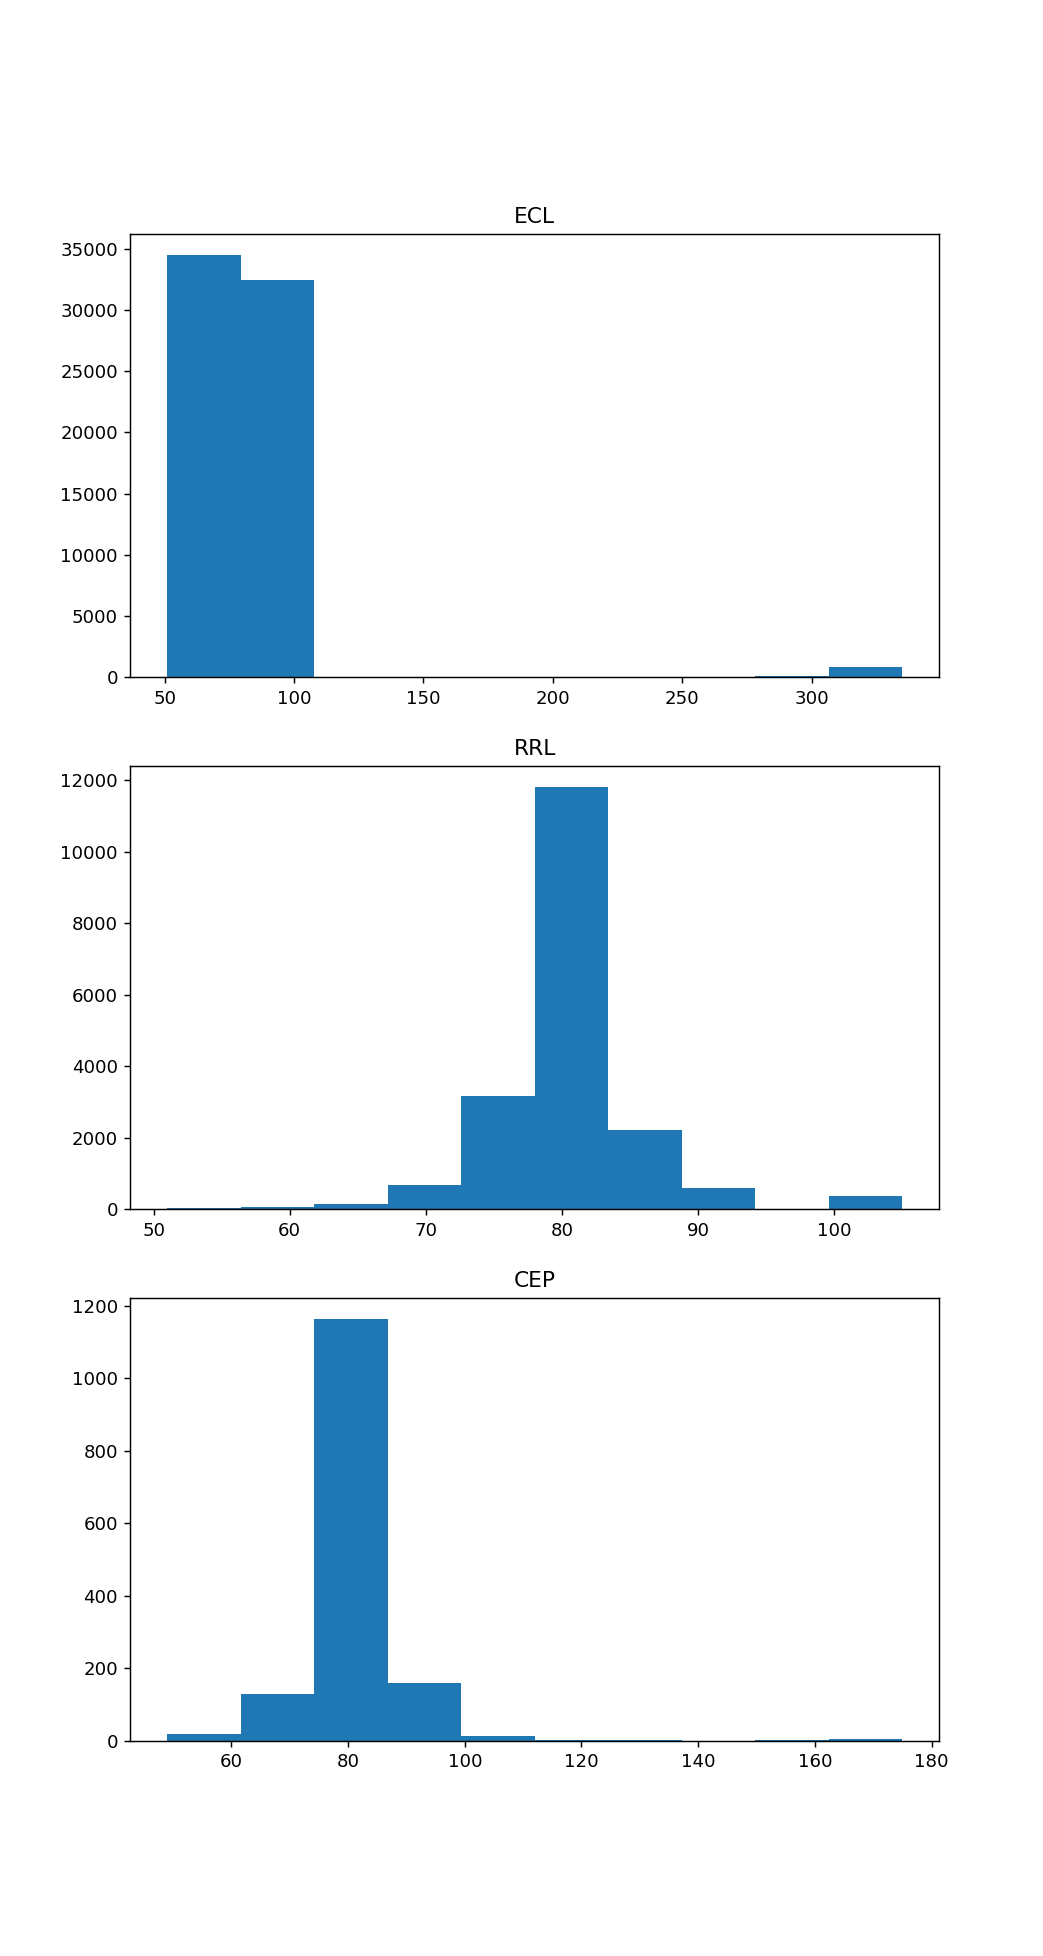

In [36]:
fig, ax = plt.subplots(3,1,figsize=(8,5*3))
for i in [0,1,2]:
    if i==0:
        ax[i].hist(muestras['ECL'])
        ax[i].set_title('ECL')
    elif i==1:
        ax[i].hist(muestras['RRL'])
        ax[i].set_title('RRL')
    else:
        ax[i].hist(muestras['CEP'])
        ax[i].set_title('CEP')

plt.show()

In [37]:
muestras['ECL'] = np.array(muestras['ECL'])
muestras['RRL'] = np.array(muestras['RRL'])
muestras['CEP'] = np.array(muestras['CEP'])

In [40]:
for i in ['ECL','RRL','CEP']:
    display(i, muestras[i].mean(),muestras[i].std())


'ECL'

82.52321247034904

28.76462951967974

'RRL'

80.38015403153979

5.635147814061115

'CEP'

80.85475234270415

8.515340958065407

In [12]:
for i in VVV:
    n = int(i['data'][:,4].numpy().sum())
    valid = np.sort(i['data'][:,3].numpy()[:n])
    print(valid[-1])
    break

1970.7128


In [14]:
# tiempo total promedoi (largo temporal) por clase
time_len = {'ECL':[],'RRL':[],'CEP':[]}
#time_std = {'ECL':[],'RRL':[],'CEP':[]}
for i in VVV:
    n = int(i['data'][:,4].numpy().sum())
    valid = np.sort(i['data'][:,3].numpy()[:n])
    largo = valid[-1]
    if (i['label'].item() == 0):
        time_len['ECL'].append(largo)
        #time_std['ECL'].append(diffs.std())
    elif i['label'].item() == 1:
        time_len['RRL'].append(largo)
        #obs_std['RRL'].append(diffs.std())
    elif i['label'].item() == 2:
        time_len['CEP'].append(largo)
        #obs_std['CEP'].append(diffs.std())

time_len['ECL'] = np.array(time_len['ECL'])
time_len['RRL'] = np.array(time_len['RRL'])
time_len['CEP'] = np.array(time_len['CEP'])

In [15]:
for i in ['ECL','RRL','CEP']:
    display(i, time_len[i].mean(), time_len[i].std())


'ECL'

1938.8225

182.60526

'RRL'

1929.4917

193.31738

'CEP'

1928.338

144.01201

In [7]:
# Tiempo medio de observaciones por curva de luz
obs_dt = {'ECL':np.array([]),'RRL':np.array([]),'CEP':np.array([])}
#obs_std = {'ECL':[],'RRL':[],'CEP':[]}
for i in VVV:
    n = int(i['data'][:,4].numpy().sum())
    valid = np.sort(i['data'][:,3].numpy()[:n])
    diffs = np.diff(valid)
    # concatenar arreglos dt por clase
    if (i['label'].item() == 0):
        obs_dt['ECL']= np.concatenate((obs_dt['ECL'],diffs))
        #obs_std['ECL'].append(diffs.std())
    elif i['label'].item() == 1:
        obs_dt['RRL']= np.concatenate((obs_dt['RRL'],diffs))
        #obs_std['RRL'].append(diffs.std())
    elif i['label'].item() == 2:
        obs_dt['CEP']= np.concatenate((obs_dt['CEP'],diffs))
        #obs_std['CEP'].append(diffs.std())


In [8]:
obs_all = np.hstack((obs_dt['ECL'],obs_dt['RRL'],obs_dt['CEP'])).ravel()

<IPython.core.display.Javascript object>


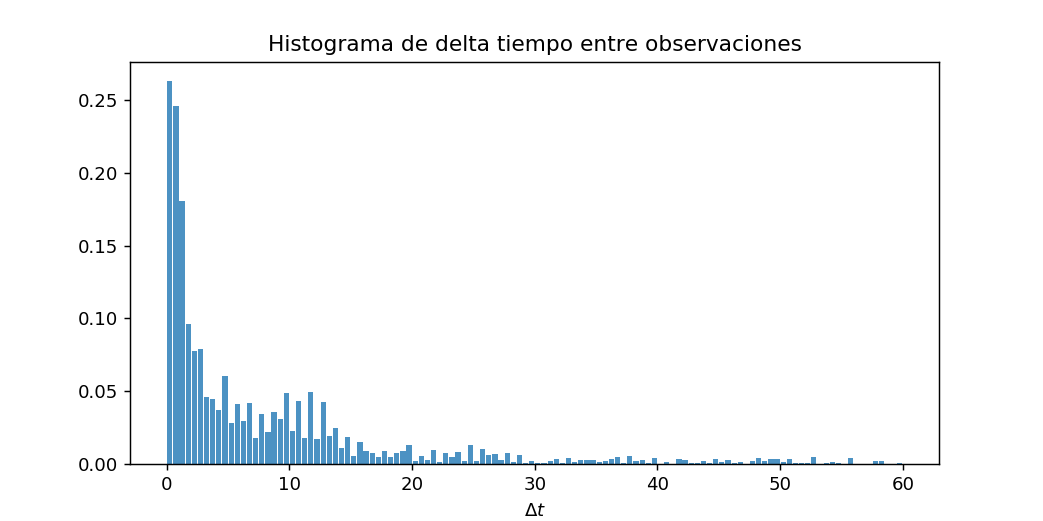

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
#for i in ['ECL','RRL','CEP']:
ax.hist(obs_all,bins=120,range=(0,60),density=True,alpha=0.8,rwidth=0.85)
    #display(i, obs_mean[i],obs_std[i])
ax.set_title('Histograma de delta tiempo entre observaciones')
ax.set_xlabel('$\Delta t$')
#ax.legend()
plt.show()

In [164]:
VVV2.__len__()

88454

In [82]:
n = int(VVV[3422]['data'][:,4].numpy().sum())
valid = np.sort(VVV[3422]['data'][:,3].numpy()[:n])
diffs = np.diff(valid)
display(valid,diffs, diffs.mean(),diffs.std())

array([0.00000000e+00, 8.87124002e-01, 7.07959518e+01, 7.37870331e+01,
       7.57570724e+01, 3.83942902e+02, 3.96835999e+02, 3.98883636e+02,
       4.13839630e+02, 4.19845093e+02, 4.35795776e+02, 5.96089600e+02,
       5.98154663e+02, 6.32055603e+02, 6.67163269e+02, 6.73030334e+02,
       6.73975952e+02, 6.86849792e+02, 6.90881104e+02, 6.96894043e+02,
       7.01967285e+02, 7.10939209e+02, 7.10962036e+02, 7.12827087e+02,
       7.14768494e+02, 7.22002014e+02, 7.36880676e+02, 7.37932190e+02,
       7.55900391e+02, 7.64893677e+02, 7.68774231e+02, 7.78812805e+02,
       7.83835388e+02, 7.90802979e+02, 8.02780945e+02, 8.03769836e+02,
       9.53081055e+02, 9.54141785e+02, 1.02318445e+03, 1.04711536e+03,
       1.09674365e+03, 1.13285486e+03, 1.13386963e+03, 1.15582043e+03,
       1.16281079e+03, 1.16879944e+03, 1.17876965e+03, 1.30911182e+03,
       1.31307605e+03, 1.32112610e+03, 1.32412097e+03, 1.37614258e+03,
       1.37704785e+03, 1.38118640e+03, 1.38695435e+03, 1.39004663e+03,
      

array([8.8712400e-01, 6.9908829e+01, 2.9910812e+00, 1.9700394e+00,
       3.0818582e+02, 1.2893097e+01, 2.0476379e+00, 1.4955994e+01,
       6.0054626e+00, 1.5950684e+01, 1.6029382e+02, 2.0650635e+00,
       3.3900940e+01, 3.5107666e+01, 5.8670654e+00, 9.4561768e-01,
       1.2873840e+01, 4.0313110e+00, 6.0129395e+00, 5.0732422e+00,
       8.9719238e+00, 2.2827148e-02, 1.8650513e+00, 1.9414062e+00,
       7.2335205e+00, 1.4878662e+01, 1.0515137e+00, 1.7968201e+01,
       8.9932861e+00, 3.8805542e+00, 1.0038574e+01, 5.0225830e+00,
       6.9675903e+00, 1.1977966e+01, 9.8889160e-01, 1.4931122e+02,
       1.0607300e+00, 6.9042664e+01, 2.3930908e+01, 4.9628296e+01,
       3.6111206e+01, 1.0147705e+00, 2.1950806e+01, 6.9903564e+00,
       5.9886475e+00, 9.9702148e+00, 1.3034216e+02, 3.9642334e+00,
       8.0500488e+00, 2.9948730e+00, 5.2021606e+01, 9.0527344e-01,
       4.1385498e+00, 5.7679443e+00, 3.0922852e+00, 1.4078735e+01,
       1.7236328e+00, 1.0324707e+00, 9.7436523e-01, 7.2736816e

24.101227

52.249493

Largo min y máx de curva de luz

In [26]:
lc_max=0
lc_min=np.inf
ind_min=0
ind_max=0
for a,i in enumerate(VVV2):
    if len(i['data'])>lc_max:
        lc_max=len(i['data'])
        ind_max=a
    if len(i['data'])<lc_min:
        lc_min=len(i['data'])
        ind_min=a
print('largo min en:',ind_min,'=',lc_min)
print('largo max en:',ind_max,'=',lc_max)

largo min en: 29355 = 49
largo max en: 26019 = 335


<IPython.core.display.Javascript object>


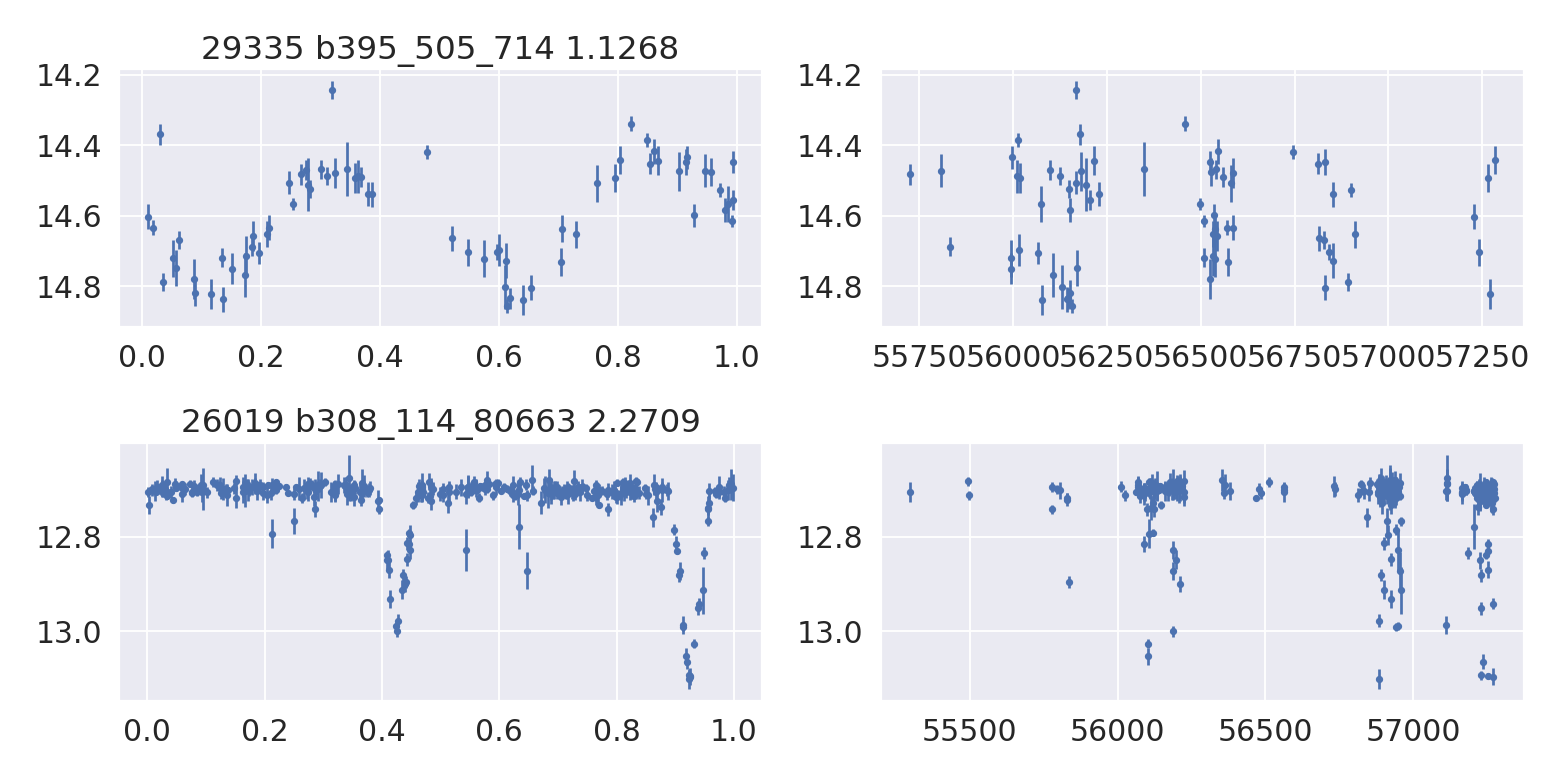

In [50]:
fig,ax=plt.subplots(2,2,figsize=(12,6),tight_layout=True)
VVV2.plot(29335,ax[0])
VVV2.plot(26019,ax[1])


<IPython.core.display.Javascript object>


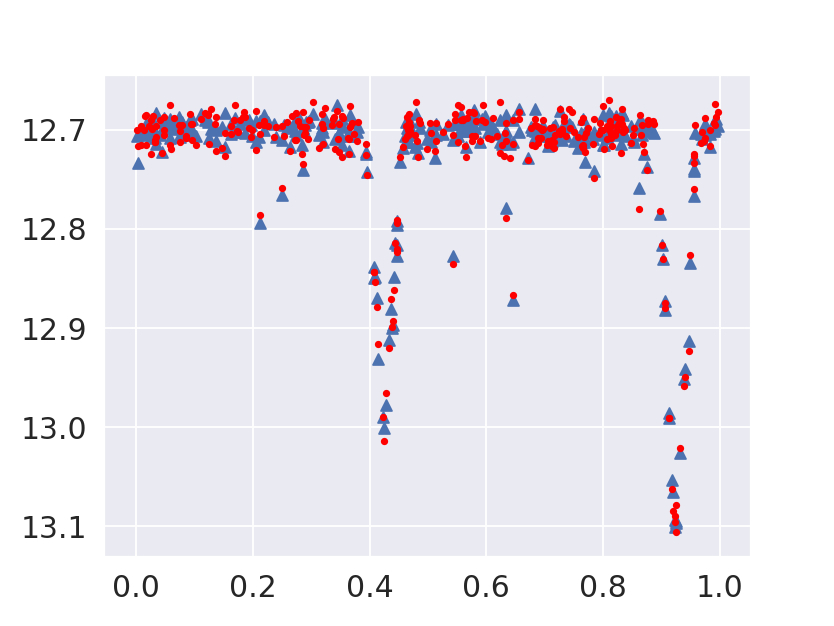

In [67]:
fig,ax =plt.subplots(1)
ej_mag = VVV2[26019]['data'][:,1].numpy()
ej2_mag = ej_mag+0.009*np.random.randn(len(ej_mag))
x = VVV2[26019]['data'][:,0].numpy()
ax.scatter(x,ej_mag,marker='^')
ax.scatter(x,ej2_mag,marker='.',color='red')
ax.invert_yaxis()
#[ax_.invert_yaxis() for ax_ in ax]


In [136]:
from ipywidgets import interact, Button, Output, Box, IntSlider, SelectionSlider
def gen_LC_n(n):
    # crear LC de largo n
    LC = {'mag':list(),'err':list()}
    x = np.linspace(0,10,num=n)
    LC['mag'] = 12+np.abs(np.sin(x) + ((-1)**n)*0.01*x + ((-1)**(n+1))*0.1*np.random.randn(n))
    LC['err'] = 0.05*np.random.randn(n)
    return LC

<IPython.core.display.Javascript object>


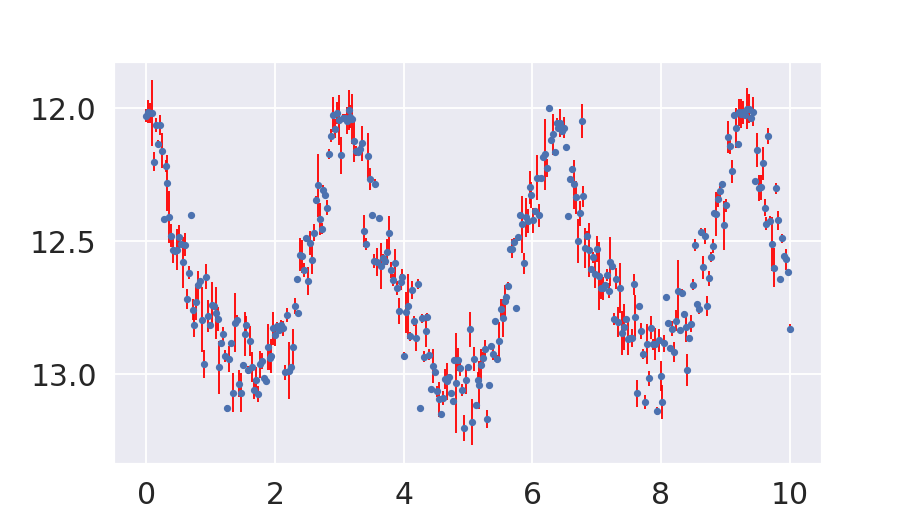

interactive(children=(SelectionSlider(description='n', options=(49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60…

<function __main__.update(n)>

In [154]:
fig,ax =plt.subplots(1,figsize=(7,4))
#LC={'mag':list(),'err':list()}
def update(n):
    x = np.linspace(0,10,num=n)
    LC = gen_LC_n(n)
    ax.cla()
    #ax.scatter(x,LC,marker='.')
    ax.errorbar(x,LC['mag'],yerr=LC['err'],ecolor='red',fmt='b.',elinewidth=1)
    ax.invert_yaxis()

interact(update, n=SelectionSlider(options=range(49,336)))

In [137]:
def lc_to_torch(LC):
    #normalizacion
    #print(LC)
    mag_std = LC["mag"].std()
    #lc_data["mjd"] = lc_data["mjd"]-lc_data["mjd"].min()
    LC["mag"] = (LC["mag"]-LC["mag"].mean())/mag_std
    LC["err"] = LC["err"]/mag_std
    #relleno
    lc_data_large = np.zeros(shape=(335, 3), dtype='float32')
    #print(LC['mag'].shape[0])
    lc_data_large[:LC['mag'].shape[0], 0] = LC['mag']
    lc_data_large[:LC['mag'].shape[0], 1] = LC['err']
    lc_data_large[:LC['mag'].shape[0], 2] = 1.

    LC_data = torch.from_numpy(lc_data_large)
    return LC_data

In [138]:
def torch_and_forward(lc,modelo):
    LC = lc_to_torch(lc)
    #forward del modelo
    with torch.no_grad():
        data,mask = LC[:,:2].unsqueeze(0).transpose(1,2),LC[:,2].unsqueeze(0).unsqueeze(1)
        #print(data.shape,mask.shape)
        modelo.forward(data,mask)

In [140]:
#LC = {'mag':list(),'err':list()}
result=list()
modelo= MLP_last()
for n in range(49,336):
    # timear cada ciclo
    LC = gen_LC_n(n)
    res = %timeit -r7 -n3 -o torch_and_forward(LC,modelo)
    result.append(res.average)

1.52 ms ± 83.3 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.68 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.93 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.49 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.46 ms ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.42 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.35 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.59 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.45 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.4 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.38 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.34 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.7 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.97 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.31 ms ± 166 µs per loop (mean 

1.37 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.38 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.45 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.31 ms ± 77.6 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.31 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.28 ms ± 78.1 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.32 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.35 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.6 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.34 ms ± 84.6 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.43 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.72 ms ± 73.6 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.81 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.53 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.77 ms ± 191 µs per loop (mean

1.38 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.31 ms ± 90.2 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.27 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.31 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.34 ms ± 48.2 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.47 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.46 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.39 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.61 ms ± 76.1 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.33 ms ± 86.7 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.52 ms ± 75.7 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.52 ms ± 88.3 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.41 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.27 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 3 loops each)
1.35 ms ± 102 µs per loop (

In [175]:
sb.set(font_scale=1.3)

In [161]:
result = np.array(result)
res_mn = result.mean()*1000
res_std = result.std()*1000
print('$%.3f' % res_mn,'\pm %.3f$' % res_std)

$1.388 \pm 0.138$


<IPython.core.display.Javascript object>


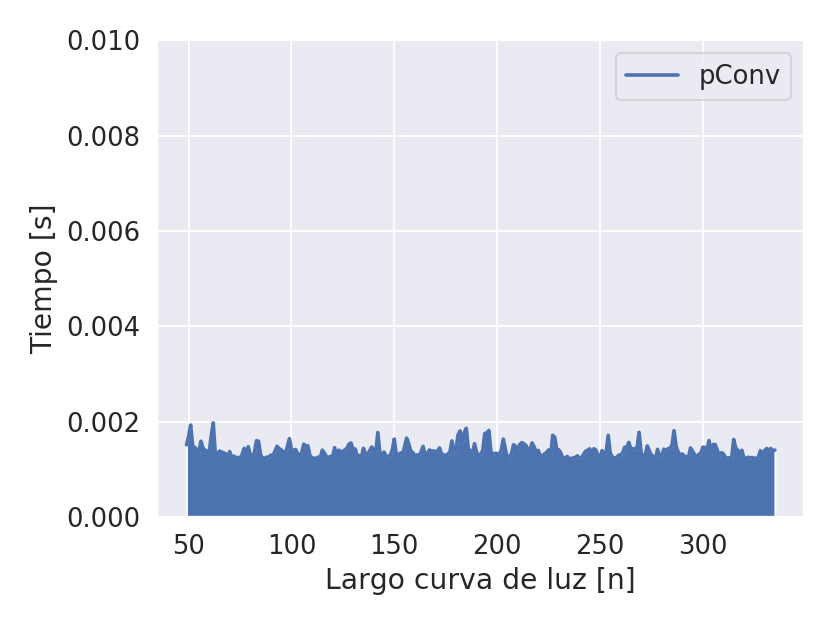

In [176]:
fig,ax=plt.subplots(1,tight_layout=True)
ax.stackplot(range(49,336),result)
ax.plot(range(49,336),result,'b-',label='pConv',alpha=1,linewidth=2)
ax.set_ylabel('Tiempo [s]')
ax.set_xlabel('Largo curva de luz [n]')
#ax.set_title('Tiempo de inferencia de una curva de luz')
ax.set_ylim([0.0,0.01])
ax.legend()
    

In [ ]:
#phase = VVV[i]['data'][:,0]
#mag = VVV[i]['data'][:,1]
#err = VVV[i]['data'][:,2]
#mask = VVV[i]['data'][:,4]
#label = VVV[i]['label'].item()
    # 0: Binary
    # 1: RRL
    # 2: Cepheid

In [53]:
n_Bin = (VVV[:]['label'].numpy() == 0).sum()
n_RRL = (VVV[:]['label'].numpy() == 1).sum()
n_Cep = (VVV[:]['label'].numpy() == 2).sum()
VVV_len = np.array([n_Bin, n_RRL, n_Cep])
VVV_len

array([67873, 19087,  1494])

### Dataloaders

In [6]:
train_valid_idx, test_idx = get_train_test_ids(df_meta,test_size=0.1)
# usar valid_idx sólo para validar, matriz de confusion final

# pasamos de tipo Int64Index a int32
#train_valid_idx, test_idx = np.array(train_valid_idx,dtype='int32'), np.array(test_idx, dtype='int32')

# slice por iloc del df_meta
df_train = df_meta.loc[train_valid_idx]
# sub dividir train_test_idx para train y test (un 20%)
train_idx, valid_idx = get_train_test_ids(df_train, test_size=0.2)

In [7]:
test_idx

Index(['b292_402_83438', 'b381_112_23559', 'b276_211_91437', 'b302_308_51394',
       'b375_616_45129', 'b262_308_53888', 'b259_616_35329', 'b292_213_30796',
       'DEK_32', 'b351_515_6740',
       ...
       'b297_306_24887', 'b298_302_24665', 'b311_306_72394', 'b366_211_33061',
       'b267_505_20705', 'b293_211_15629', 'b348_416_64838', 'b283_211_27467',
       'b362_106_54099', 'b387_602_1121'],
      dtype='object', name='ID_VVV', length=8846)

In [8]:
from collections import Counter

display(Counter(list(df_meta.loc[train_idx]["label"])))
display(Counter(list(df_meta.loc[test_idx]["label"])))
display(Counter(list(df_meta.loc[valid_idx]["label"])))

Counter({'binary': 48897, 'rrlyrae': 13742, 'cepheid': 1077})

Counter({'binary': 6790, 'rrlyrae': 1909, 'cepheid': 149})

Counter({'binary': 12222, 'cepheid': 270, 'rrlyrae': 3436})

In [12]:
def make_dataloaders(dataset,use_IDS,split,train_size=32,test_size=64):
    global train_idx
    global valid_idx
    if use_IDS:
        # ImbalancedDatasetSampler
        #train_idx, valid_idx= train_test_split(
        #                                np.arange(len(dataset)),
        #                                test_size=split,
        #                                shuffle=True,
        #                                stratify=dataset[:]['label'])
        #train_idx, valid_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(dataset,
                          sampler=ImbalancedDatasetSampler(dataset,
                                                           indices=train_idx,
                                                           callback_get_label= lambda dataset, idx:dataset[idx]['label'].item()),
                          batch_size=train_size, shuffle=False)

        valid_loader= DataLoader(dataset,
                                sampler=SubsetRandomSampler(valid_idx),
                                batch_size=test_size, shuffle=False)
    else:
        train_idx, test_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(train_idx),
                                batch_size=train_size, shuffle=False)

        valid_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(valid_idx),
                                batch_size=test_size, shuffle=False)
    return train_loader, valid_loader

### Def. Modelo NN

In [16]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask

In [20]:
class MLP_last(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=3): 
        super(MLP_last, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
        
        #print("B4 C1:", x.shape,mask.shape)
        x, mask = self.pconv1(x, mask)
        #print("after C1:", x.shape,mask.shape)
        x = self.activation(x)
        x, mask = self.pconv2(x, mask)
        #print("after C2:", x.shape,mask.shape)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        #print("after C3:", x.shape)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        #print("after gap:", z.shape)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        #print("after L1:", z.shape)
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        #print("after L2:", z.shape)
        fuera = self.output(z)
        #print("after L3:", fuera.shape)
        return fuera



In [67]:
class MLP_lastB(torch.nn.Module):
    def __init__(self, in_channels_C=2,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=3): 
        super(MLP_lastB, self).__init__()
        self.pconv1 = nn.Conv1d(in_channels_C, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = nn.Conv1d(c4, c3, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = nn.Conv1d(c3, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x, t=0):
        if t==1:
            x = x.transpose(0,1)
            #mask = mask.transpose(0,1)
        elif t==2:
            x = x.transpose(1,2)
            #mask = mask.transpose(1,2)
    
        #x, mask = self.pconv1(x, mask)
        x = self.pconv1(x)
        x = self.activation(x)
        #x, mask = self.pconv2(x, mask)
        x = self.pconv2(x)
        x = self.activation(x)
        #x, mask = self.pconv3(x, mask)
        x = self.pconv3(x)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [32]:
class MLP_lastB3(torch.nn.Module):
    def __init__(self, in_channels_C=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=3): 
        super(MLP_lastB3, self).__init__()
        self.pconv1 = nn.Conv1d(in_channels_C, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = nn.Conv1d(c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = nn.Conv1d(c4, c2, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(1)
        
        self.hidden1 = torch.nn.Linear(c2*1, hid_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x, t=0):
        if t==1:
            x = x.transpose(0,1)
            #mask = mask.transpose(0,1)
        elif t==2:
            x = x.transpose(1,2)
            #mask = mask.transpose(1,2)
    
        #x, mask = self.pconv1(x, mask)
        x = self.pconv1(x)
        x = self.activation(x)
        #x, mask = self.pconv2(x, mask)
        x = self.pconv2(x)
        x = self.activation(x)
        #x, mask = self.pconv3(x, mask)
        x = self.pconv3(x)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,64*1)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [253]:
modelo = MLP_last()
display(modelo)

MLP_last(
  (pconv1): PartialConv(
    (input_conv): Conv1d(2, 16, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(1, 16, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv2): PartialConv(
    (input_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(16, 16, kernel_size=(3,), stride=(2,), bias=False)
  )
  (pconv3): PartialConv(
    (input_conv): Conv1d(16, 64, kernel_size=(3,), stride=(2,))
    (mask_conv): Conv1d(16, 64, kernel_size=(3,), stride=(2,), bias=False)
  )
  (gap): AdaptiveMaxPool1d(output_size=1)
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
  (activation): ReLU()
)

In [254]:
total_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)
total_params

6691

#### BetaTesting-b4-Train

**Check GPU**

In [9]:
cuda.is_available()

True

In [10]:
torch.cuda.current_device()

0

In [17]:
torch.cuda.set_device('cuda:0')

### ENTRENAMIENTO

Path nombre modelo
**LCC_newDataset_model_0x_sample_n**
- 01:
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='weighted'
    - IDS: True
  
- 02:
    - Data: Magnitud
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='micro'
    - IDS: True

- 03:
    - Data: Magnitud
    - Mask: False
    - Concolution: 1D (usual)
    - f1_acum average='macro'
    - IDS: True

- 04:
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: True

- 04b (just sample0):
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: FALSE
 
- 04c (same 4b but less epochs and patience):
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: FALSE
 
- 04d (same 4c but IDS true):
    - Data: magnitud, error
    - Mask: True
    - Convolution: partial (masked)
    - f1_acum average='MACRO'
    - IDS: True
    
- 05:
    - Data (canales): magnitud, error
    - mask: False
    - Convolution: 1D (usual)
    - f1_acum average='MACRO'
    - IDS: True

- 06: Introducir Periodo a la última y algunas features "clásicas" (al mejor modelo de ConvParcial)

- 07: Entrenar sin Zero-Padding
    - Batch tamaño 1
    - convolucional 1D

In [16]:
n_model = '04'
path_models = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/models/'
path_results = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/results/'
model_name = 'LCC_newDataset_model_'+n_model+'_'
path = path_models+model_name

In [17]:
def update_plot(ax,TL,VL,F1,last_ep_f1,best_f1,topf1_logs):
    #global comentario
    titulo="Current Training:"+' '+model_name+" Sample="+str(s)
    [ax_.cla() for ax_ in ax]
    # plot 0 : TL, VL, last_ep
    ax[0].plot(range(len(TL)), TL, lw=2, label='Train Loss')
    ax[0].plot(range(len(VL)), VL, lw=2, label='Valid Loss')
    #ax[0].axvline(last_ep_vl,c='r',marker='|',lw=1,label="Last improve")
    #ax[1].plot(range(len(F1)),np.full_like(F1,max(F1)),'r--',lw=1, label='best F1')
    # plot 1 : F1, topf1_logs
    ax[1].plot(range(len(F1)), F1, lw=2, label='F1 score')
    label_epoch = "Last improve "+str(last_ep_f1)
    ax[1].axvline(last_ep_f1,c='r',marker='|',lw=1,label=label_epoch)
    if len(topf1_logs)==0:
        # plot topf1 actual
        label_f1 = 'top F1 actual '+str('%.3f'%(max(F1)))
        ax[1].plot(range(len(F1)),np.full_like(F1,max(F1)),'r--',lw=1, label=label_f1)
        
    else:
        # plot topf1 mean
        # revisar ultima epoca subida f1
        label_f1 = 'top F1 '+str('%.3f'%(best_f1))
        ax[1].plot(range(len(F1)),np.full_like(F1,best_f1),'r--',lw=1, label=label_f1)
        ax[1].plot(range(len(F1)),np.full_like(F1,np.mean(topf1_logs)),'g--',lw=1, label='mean F1 hist')
    [ax_.set_xlabel('Epochs') for ax_ in ax]
    [ax_.grid() for ax_ in ax]
    [ax_.legend() for ax_ in ax]
    fig.suptitle(titulo)
    fig.canvas.draw()
    fig.canvas.flush_events()

In [21]:
# MODELO [01,04], 2 canales(mag,err), Mask
# ajustes a condiciones de término de entrenamiento y guardado
def training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, valid_loader,path_full,path_save,ax,topf1_logs):
    optimizer = torch.optim.Adam(modelo.parameters(), lr=lr,weight_decay=wd)
    #ultima_mejora --> VL, 
    # ambas por época (no cambian juntas)
    #ultima_mejora = 0
    paciencia = 300
    ultima_subida_f1 = 0
    best_valid,best_f1= np.inf,0.0
    # Historiales por épocas
    TL,VL,F1=list(),list(),list()

    for k in tqdm(epochs):
        if (k-ultima_subida_f1 >= paciencia):
            print("Hace al menos ", paciencia," épocas NO aumenta F1 Score macro. Best F1=",best_f1)
            # guardar plot 
            plt.savefig(path_save)
            break
        
        train_loss, valid_loss,f1_acum = 0.0, 0.0, 0.0
        # Loop de entrenamiento
        for batch in train_loader:
            
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            #break
            data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
            #display(data.shape,mask.shape)
            #display(data,mask)
            optimizer.zero_grad()
            outputs = modelo.forward(data,mask,t=0)
            #display(outputs.shape,labels.shape)
            #break
            loss = criterion(outputs,labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        TL.append(train_loss/train_loader.__len__()) 

        # VALIDACION 
        for batch in valid_loader:
            #actual_f1 = f1_acum/test_loader.__len__()
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
            
            y_true=labels.cpu().numpy()
            #display(y_true)
            #break
            outputs = modelo.forward(data,mask,t=0)
            # F1 score
            y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
            #print(y_pred)
             # cambio 'weighted' por 'macro' (seguro? no será 'micro'?)
            f1_acum += f1_score(y_true, y_pred, average='macro')
            loss = criterion(outputs,labels)
            #print(loss.item())
            valid_loss += loss.item()
            #print(valid_loss)
            # save best model
        # usar F1 como condición para guardar
        f1_last = f1_acum/valid_loader.__len__()
        valid_loss_last = valid_loss/valid_loader.__len__()
        if f1_last > best_f1:
            ultima_subida_f1 = k
            #print("vamos mejorando :) epoch=",k+1)
            #best_valid = valid_loss
            best_f1 = f1_last
            torch.save({'epoca': k,
                        'f1_score': best_f1,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'Valid_loss': valid_loss_last}, path_full)
        VL.append(valid_loss_last)
        F1.append(f1_last)
        update_plot(ax,TL,VL,F1,ultima_subida_f1,best_f1,topf1_logs)

    # Retornar modelo a la CPU
    if use_gpu:
        modelo = modelo.cpu()
        #print("ok")
    return best_f1

In [33]:
# MODELO 03, 1 canal (mag), Mask
# MODELO 05, 2 canales (mag,err)
def training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, valid_loader,path_full,path_save,ax,topf1_logs):
    optimizer = torch.optim.Adam(modelo.parameters(), lr=lr,weight_decay=wd)
    paciencia = 300
    ultima_subida_f1 = 0
    best_valid,best_f1= np.inf,0.0
    # Historiales por épocas
    TL,VL,F1=list(),list(),list()

    for k in tqdm(epochs):
        if (k-ultima_subida_f1 >= paciencia):
            print("Hace al menos ", paciencia," épocas NO aumenta F1 Score macro. Best F1=",best_f1)
            # guardar plot 
            plt.savefig(path_save)
            break
        train_loss, valid_loss,f1_acum = 0.0, 0.0, 0.0
        # Loop de entrenamiento
        for batch in train_loader:
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            #data,mask = inputs[:,1].unsqueeze(0).transpose(0,1),inputs[:,4].unsqueeze(0).transpose(0,1)
            data = inputs[:,[1,2]]
            #display(data.shape)
            #display(data)
            data = data.type(torch.cuda.FloatTensor)
            optimizer.zero_grad()
            outputs = modelo.forward(data,t=0)
            #display(outputs.shape,labels.shape)
            #break
            loss = criterion(outputs,labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        TL.append(train_loss/train_loader.__len__()) 
        #break
        # VALIDACION 
        for batch in valid_loader:
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            #data,mask = inputs[:,1].unsqueeze(0).transpose(0,1),inputs[:,4].unsqueeze(0).transpose(0,1)
            data = inputs[:,[1,2]]
            y_true=labels.cpu().numpy()
            #display(y_true)
            #break
            data = data.type(torch.cuda.FloatTensor)
            outputs = modelo.forward(data,t=0)
            # F1 score
            y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
            #print(y_pred)
             # cambio 'weighted' por 'macro'
            f1_acum += f1_score(y_true, y_pred, average='macro')
            loss = criterion(outputs,labels)
            #print(loss.item())
            valid_loss += loss.item()
            #print(valid_loss)
            # save best model
        # usar F1 como condición para guardar
        f1_last = f1_acum/valid_loader.__len__()
        valid_loss_last = valid_loss/valid_loader.__len__()
        if f1_last > best_f1:
            ultima_subida_f1 = k
            #print("vamos mejorando :) epoch=",k+1)
            #best_valid = valid_loss
            best_f1 = f1_last
            torch.save({'epoca': k,
                        'f1_score': best_f1,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'Valid_loss': valid_loss_last}, path_full)
        VL.append(valid_loss_last)
        F1.append(f1_last)
        update_plot(ax,TL,VL,F1,ultima_subida_f1,best_f1,topf1_logs)

    # Retornar modelo a la CPU
    if use_gpu:
        modelo = modelo.cpu()
        #print("ok")
    return best_f1

Parametros generales

In [34]:
n_epochs=3000
lr=0.0002
wd = 0
epochs = range(n_epochs)
use_gpu = True
use_IDS = True
criterion = torch.nn.CrossEntropyLoss()
semilla=774892200
rs=RandomState(semilla)
split,train_size,test_size=0.3,32,64
sb.set(font_scale=1.0)

<IPython.core.display.Javascript object>


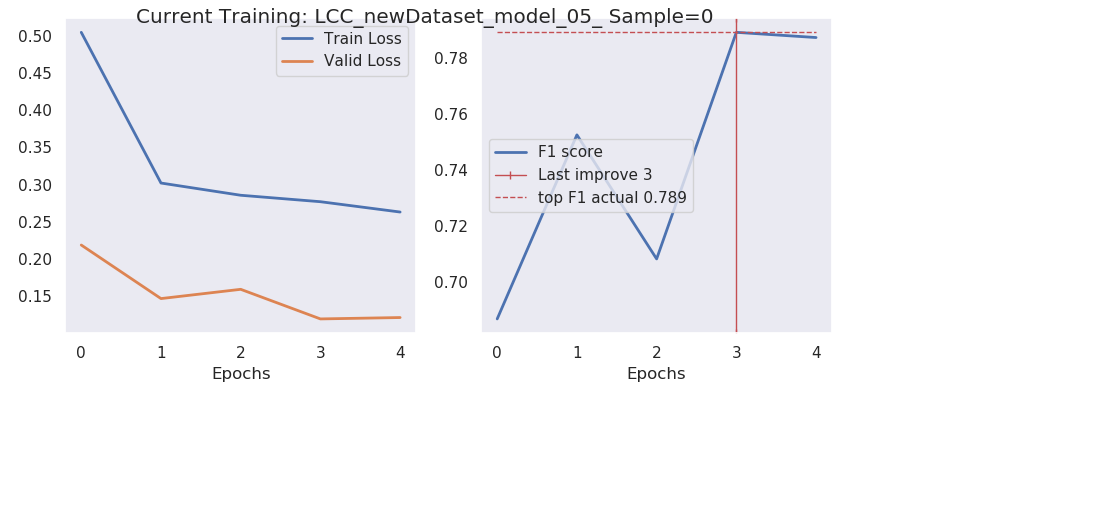


Begin Training new Dataset


In [ ]:
# New Dataset (Jun 2020)
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=True, sharex=True)
top5f1=list()
prompt="Training new Dataset"
print("\nBegin",prompt)
for s in [0,1,2,3,4,5]: 
    comentario = "sample_"+str(s)
    path_full = path+comentario+'.pt'
    path_save = path_results+model_name+comentario+'.png'
    # DataLoaders
    train_loader, valid_loader = make_dataloaders(VVV,use_IDS,split,train_size,test_size)
    # ENTRENAR
    modelo=MLP_lastB()
    if use_gpu:
        modelo=modelo.cuda()
    topf1 = training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, valid_loader,path_full,path_save,ax,top5f1)
    top5f1.append(topf1)

# return f1 mean, f1 std
print("Results: F1-Score-Macro mean=",np.mean(top5f1),"F1-Score-Macro std=",np.std(top5f1))
print("End",prompt)
print("-------END-------")

**Matriz de Confusión**

In [12]:
def make_path(n,s):
    n_model = '0'+str(n)
    #path = '/home/amorales/tesis/LC_test/models/LCC_newDataset_model_'+n_model+'_'
    path = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/models/LCC_newDataset_model_'+n_model+'_'
    comentario = "sample_"+str(s)
    path_full = path+comentario+'.pt'
    return path_full

In [13]:
def load_besto_model(path_full,m_type):
    if m_type=='A':
        besto = MLP_last()
    elif m_type=='B':
        besto = MLP_lastB()
    elif m_type=='B3':
        besto = MLP_lastB3()
    besto.load_state_dict(torch.load(path_full,map_location='cuda:0')['model_state_dict'])
    return besto

In [14]:
# MODIFICADA New Dataset (Jun 2020)
#y_true = [best_of_best[i]['label'].item() for i in range(len(best_of_best))]
#y_true = [VVV[i]['label'].item() for i in valid_idx]
def evaluate_model(besto,test_loader,m_type):
    prediction_test = []
    labels_test=[]
    if m_type=='A':
        for batch in test_loader:
            inputs, labels = batch['data'],batch['label']
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
            labels_test.append(labels.detach().numpy())
            #y_true=labels.cpu().numpy()
            #display(y_true)
            #break
            outputs = besto.forward(data,mask,t=0)
            # F1 score
            y_pred=outputs.detach().argmax(dim=1).numpy()
            #print(outputs)
            prediction_test.append(outputs.detach().argmax(dim=1).numpy())
            
    elif (m_type=='B') or (m_type=='B3'):
        if use_gpu:
            besto = besto.cuda()
        for batch in test_loader:
            inputs, labels = batch['data'],batch['label']
            inputs = inputs.transpose(1,2)
            #if use_gpu:
            #    inputs, labels = inputs.cuda(), labels.cuda()
            #display(inputs.shape,labels.shape)
            #model 3
            if m_type=='B3':
                data = inputs[:,1]
                data = data.unsqueeze(0).transpose(0,1)
            elif m_type=='B':
                #model 5
                data = inputs[:,[1,2]]
            #display(data.shape)
            #display(data.shape)
            data = data.type(torch.cuda.FloatTensor)
            labels_test.append(labels.detach().numpy())
            #y_true=labels.cpu().numpy()
            #display(y_true)
            #outputs = besto.forward(data,mask,t=0)
            outputs = besto.forward(data,t=0)
            # F1 score
            y_pred=outputs.detach().argmax(dim=1).cpu().numpy()
            #print(outputs)
            prediction_test.append(outputs.detach().argmax(dim=1).cpu().numpy())

    y_true = np.concatenate(labels_test)
    y_pred = np.concatenate(prediction_test)
    return y_true,y_pred


In [15]:
def results(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cr = classification_report(y_true, y_pred,target_names=stars,output_dict=True)
    return cm,cr

In [15]:
def mk_test(m_type):
    if m_type=='A':
        dataset = VVV
        bs = 32
    elif (m_type=='B') or (m_type=='B3'):
        dataset = VVV2
        bs = 1
    
    test_loader= DataLoader(dataset,
                            sampler=SubsetRandomSampler(test_idx),
                            batch_size=bs, shuffle=False)
    return test_loader

In [128]:
train_idx, valid_idx = list(train_idx), list(valid_idx)
train_loader = DataLoader(VVV,
                        sampler=SubsetRandomSampler(train_idx),
                        batch_size=32, shuffle=False)

valid_loader = DataLoader(VVV,
                        sampler=SubsetRandomSampler(valid_idx),
                        batch_size=64, shuffle=False)

In [22]:
stars = ['ECL','RRL','CEP']
#cmap = sb.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sb.light_palette("seagreen", as_cmap=True)
sb.set(font_scale=1.7)

In [23]:
N_model,m_type = '4','A'
#model_samples = [1,2,7,9,12] #m04
#model_samples = [0,1,2,3,4,5] #m05
#model_samples = [0,1,3,4,5] #m03
#model_samples = [0,1,2] #m04c
model_samples = [1] #test
test_loader = mk_test(m_type)
METRICAS = {'Pr':[],'Rc':[],'F1':[],'BAcc':[]}
#blnc_acc_arr = list()

show_cm = True
use_gpu = True
CM = np.zeros((len(model_samples),3,3))

In [97]:
EP = []
for i,s in enumerate(model_samples):
    path_ = make_path(N_model,s)
    ep_ = torch.load(path_,map_location='cuda:0')['epoca']
    EP.append(ep_)
    #print(ep_)
EP = [210, 301, 350, 243, 503]
EP = np.array(EP)

print(EP,'$%.3f' % EP.mean(),'\pm %.3f$' % EP.std())

[210 301 350 243 503] $321.400 \pm 102.732$


In [68]:
#fig,ax = plt.subplots(4,1,figsize=(7,5*4))
for i,s in enumerate(model_samples):
    path_ = make_path(N_model,s)
    modelo = load_besto_model(path_,m_type)
    y_t, y_p = evaluate_model(modelo, test_loader,m_type)
    bl_acc = balanced_accuracy_score(y_t,y_p)
    METRICAS['BAcc'].append(bl_acc)
    cm, cr = results(y_t,y_p)
    CM[i,:,:]=cm
    METRICAS['Pr'].append(cr['macro avg']['precision'])
    METRICAS['Rc'].append(cr['macro avg']['recall'])
    METRICAS['F1'].append(cr['macro avg']['f1-score'])
    #display(cm,cr)

for i in ['Pr','Rc','F1','BAcc']:
    METRICAS[i] = np.array(METRICAS[i])
    

In [71]:
CM[0]

array([[9.89687684e-01, 9.57572186e-03, 7.36593989e-04],
       [1.41435306e-02, 9.51807229e-01, 3.40492404e-02],
       [1.34228188e-02, 2.28187919e-01, 7.58389262e-01]])

In [57]:
   
print("|     Precision     |       Recall      |      F1-score     |     Bal. Acc.    |")
for i in ['Pr','Rc','F1','BAcc']:
    print('& %.3f' % METRICAS[i].mean(),'$\pm$ %.3f' % METRICAS[i].std(),end=' ')

|     Precision     |       Recall      |      F1-score     |     Bal. Acc.    |
& 0.535 $\pm$ 0.009 & 0.722 $\pm$ 0.014 & 0.568 $\pm$ 0.012 & 0.722 $\pm$ 0.014 

<IPython.core.display.Javascript object>


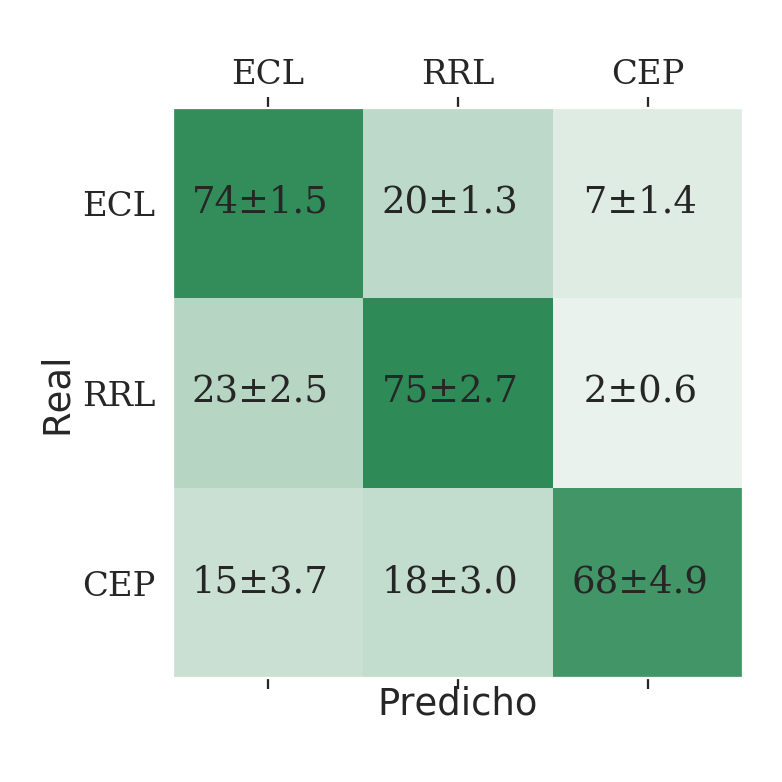

In [58]:
cm_avg = np.mean(CM,axis=0)
cm_std = np.std(CM,axis=0)
cm_labels = pd.DataFrame([[f'{cm_avg[i,j]:0.3f}±{cm_std[i,j]:0.3f}' for i in range(3)] for j in range(3)])
fig, ax = plt.subplots(figsize=(6, 6),tight_layout=True)
ax.matshow(cm_avg, cmap=cmap)
ax.set_xticks(range(3))
ax.set_xticklabels(stars,family='serif')
ax.set_yticks(range(3))
ax.set_yticklabels(stars,family='serif')
ax.set_xlabel('Predicho')
ax.set_ylabel('Real')
for i in range(3):
    for j in range(3):
        ax.text(i-0.4, j+0.05, f'{100*cm_avg[j,i]:2.0f}±{100*cm_std[j,i]:0.1f}',family='serif')
ax.grid(False)

In [ ]:
lc_classes = {"label":{"binary":0, "rrlyrae":1, "cepheid":2}}

### Comparación entre distintos Modelos
Historial Matrices de Confusion [https://docs.google.com/spreadsheets/d/1j9kseGSx1WQvkb1C4nDL5J-lweuH3VyPsrAT50E1D6w/edit#gid=0]

**Random Forest**

In [25]:
from joblib import load, dump
with open("/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/features_fats_all.pkl", "rb") as f:
    features = load(f)
with open("metadata4rf.pkl", "rb") as f:
    df_meta_rf = load(f)

In [26]:
df_meta_rf

,P1,P2,P_ogle,label
ID_VVV,,,,
b221_201_22183,13.972335,6.986167,13.970992,binary
b221_205_41463,21.537799,10.770059,21.541892,binary
b232_614_24529,8.035356,16.069420,16.065114,binary
b233_201_30278,8.750438,4.374645,8.751487,binary
b233_201_16631,44.130627,22.070183,44.161985,binary
...,...,...,...,...
b395_201_28153,0.316792,0.633585,0.316787,rrlyrae
b395_205_6265,0.287350,0.574699,0.287350,rrlyrae
b395_304_9934,0.355847,0.711693,0.355842,rrlyrae


In [27]:
df_meta

,P1,P2,P_ogle,label
ID_VVV,,,,
b221_201_22183,13.972335,6.986167,13.970992,0
b221_205_41463,21.537799,10.770059,21.541892,0
b232_614_24529,8.035356,16.069420,16.065114,0
b233_201_30278,8.750438,4.374645,8.751487,0
b233_201_16631,44.130627,22.070183,44.161985,0
...,...,...,...,...
b395_201_28153,0.316792,0.633585,0.316787,1
b395_205_6265,0.287350,0.574699,0.287350,1
b395_304_9934,0.355847,0.711693,0.355842,1


In [39]:
from os.path import join, exists

if not exists('../models/best_rf_balanced.pkl.xz'):
    !pip install gdown
    import gdown
    gdown.download("https://drive.google.com/u/1/uc?export=download&confirm=7p4B&id=1QzNS-wCCsPmEpbz0wjcEUqjsUvy5AkRL", 
                   "../models/best_rf_balanced.pkl.xz")

with open("../models/best_rf_balanced.pkl.xz", "rb") as f:
    best_model = load(f)    

/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [94]:
#from sklearn.metrics import confusion_matrix, classification_report

#test_loader = mk_test('A')

y_pred = best_model.predict(features.loc[test_idx].fillna(0).values)
y_pred = [0 if i=='binary' else i for i in y_pred]
y_pred = [1 if i=='rrlyrae' else i for i in y_pred]
y_pred = [2 if i=='cepheid' else i for i in y_pred]
y_pred = np.array(y_pred)

y_true = df_meta_rf.loc[test_idx]["label"]



In [117]:
print((y_pred),(y_true))


[0 0 0 ... 1 0 1] ID_VVV
b365_312_36989     0
b279_604_76585     0
b387_302_32644     0
b366_513_57300     0
b290_306_69877     0
                  ..
b291_505_101903    0
b295_114_132413    0
b376_306_5581      1
b281_503_41797     0
b361_314_30190     1
Name: label, Length: 8847, dtype: int64


In [24]:
test_idx

Int64Index([66458,  7865, 32339, 19365, 41283, 41177, 67667,  5836, 22283,
            68262,
            ...
            59269, 71983, 81277, 41097, 55245, 41639, 25191, 85671,   715,
            82829],
           dtype='int64', name='idx', length=8846)

In [ ]:
# RRL in test_set = 1909

In [95]:
id_true_rrl = df_meta.loc[test_idx].loc[df_meta.loc[test_idx].label=='rrlyrae'].index.values
mask = best_model.predict(features.loc[test_idx].fillna(0).values) == 'rrlyrae'
id_rf_rrl = features.loc[test_idx].index[mask].values
id_rf_true_rrl = set(id_true_rrl).intersection(set(id_rf_rrl))

In [41]:
id_true_rrl = df_meta.loc[test_idx].loc[df_meta.loc[test_idx].label=='rrlyrae'].index.values
mask = best_model.predict(features.loc[test_idx].fillna(0).values) == 'rrlyrae'
id_rf_rrl = features.loc[test_idx].index[mask].values
id_rf_true_rrl = set(id_true_rrl).intersection(set(id_rf_rrl))

/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


KeyError: "None of [Int64Index([66458,  7865, 32339, 19365, 41283, 41177, 67667,  5836, 22283,\n            68262,\n            ...\n            59269, 71983, 81277, 41097, 55245, 41639, 25191, 85671,   715,\n            82829],\n           dtype='int64', name='oid', length=8846)] are in the [index]"

In [178]:
id_rf_true_rrl.__len__()/1909

0.9188056574122577

In [116]:
# TP of RF
rrl_RF = test_idx[(y_true.values==1) & (y_pred==1)]
rrl_RF.__len__()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8846 but corresponding boolean dimension is 8847

In [96]:
set_RF = set(rrl_RF)
set_RF

{73728,
 73736,
 81932,
 81935,
 73750,
 73751,
 81942,
 73753,
 81946,
 81947,
 73757,
 81956,
 81959,
 81961,
 73781,
 81980,
 73791,
 81988,
 81993,
 81994,
 81996,
 82003,
 82006,
 82007,
 73830,
 73838,
 73839,
 73843,
 73845,
 82046,
 82052,
 73868,
 82069,
 82070,
 82073,
 73889,
 73894,
 82095,
 82097,
 73911,
 73913,
 73917,
 73924,
 82136,
 82143,
 73954,
 73957,
 73964,
 73970,
 82163,
 82194,
 82195,
 74009,
 74012,
 82211,
 82220,
 74040,
 74045,
 74052,
 82245,
 74060,
 74063,
 82259,
 82261,
 74074,
 74076,
 74078,
 74079,
 82271,
 82284,
 74092,
 82288,
 82291,
 82292,
 74100,
 82294,
 82295,
 74107,
 74109,
 82305,
 82307,
 74117,
 82311,
 82314,
 82323,
 82346,
 82356,
 74169,
 74170,
 74182,
 74185,
 82386,
 74200,
 82404,
 74216,
 74223,
 74234,
 74235,
 82430,
 74239,
 82432,
 82435,
 74243,
 82437,
 82438,
 82457,
 74268,
 82466,
 74275,
 82468,
 82482,
 82484,
 82489,
 82502,
 82504,
 82505,
 74316,
 74324,
 74331,
 74334,
 82531,
 82534,
 74343,
 82536,
 74348,


mismo set para CNN y luego hacer diferencia e interseccion

In [200]:
test_idx

Index(['b365_312_36989', 'b279_604_76585', 'b387_302_32644', 'b366_513_57300',
       'b290_306_69877', 'b290_102_71549', 'b378_114_34902', 'b273_106_54853',
       'b387_406_18996', 'b381_112_23559',
       ...
       'b283_209_45611', 'b266_314_83147', 'b348_610_51377', 'b289_505_82771',
       'b252_304_15240', 'b291_505_101903', 'b295_114_132413', 'b376_306_5581',
       'b281_503_41797', 'b361_314_30190'],
      dtype='object', name='ID_VVV', length=8846)

In [250]:
df_meta.iloc[test_idx]

,ID_VVV,P1,P2,P_ogle,label
idx,,,,,
66458,b365_312_36989,0.244569,0.489139,0.489141,0
7865,b279_604_76585,1.511693,3.023340,3.023417,0
32339,b387_302_32644,0.415856,0.713343,0.831715,0
19365,b366_513_57300,3.043677,6.087539,6.087399,0
41283,b290_306_69877,0.831511,0.415754,0.831493,0
...,...,...,...,...,...
41639,b291_505_101903,0.320387,0.381499,0.320388,0
25191,b295_114_132413,1.192933,0.543192,2.385878,0
85671,b376_306_5581,0.566919,1.133838,0.566907,1


In [252]:
VVV_test = LightCurve_Dataset(df_meta.loc[test_idx])

KeyError: 0

In [33]:
N_model,m_type,s='4','A',1
path_ = make_path(N_model,s)
modelo = load_besto_model(path_,m_type)
test_loader = mk_test(m_type)
#VVV_test = torch.utils.data.Subset(VVV,test_idx)
#test_loader = DataLoader(VVV_test,batch_size=64,sampler=None,shuffle=False)
y_t, y_p = evaluate_model(modelo, test_loader,m_type)

In [47]:
y_p

array([1, 0, 0, ..., 0, 0, 0])

In [48]:
cm = confusion_matrix(y_t,y_p)
cm

array([[6718,   65,    5],
       [  27, 1817,   65],
       [   2,   34,  113]])

In [28]:
VVV.name[test_idx[0]]

'b365_312_36989'

In [50]:
set(VVV.name.values).intersection(set_CNN).__len__()

0

In [127]:
cm_RF = confusion_matrix(y_true,y_pred,labels=[0, 1, 2])
cm_CNN = confusion_matrix(y_t,y_p,labels=[0, 1, 2])
cm_CNN

array([[6718,   65,    5],
       [  27, 1817,   65],
       [   2,   34,  113]])

In [53]:
rrl_CNN = test_idx[(y_t==1) & (y_p==1)]
rrl_CNN.__len__()/1909

0.9518072289156626

In [57]:
df_meta_rf.loc['b286_513_35283']

P1        0.610844
P2         1.57659
P_ogle      1.2217
label       binary
Name: b286_513_35283, dtype: object

In [54]:
VVV.name[rrl_CNN]

idx
32794    b242_511_31154
25805    b305_402_18151
24587    b286_513_35283
3846     b260_207_66594
75388    b290_102_98968
              ...      
5447     b267_505_20705
24981    b293_211_15629
71983    b266_314_83147
81277    b348_610_51377
41097    b289_505_82771
Name: ID_VVV, Length: 1817, dtype: object

In [49]:
set_CNN = set(rrl_CNN)
set_CNN

{24587,
 81932,
 49167,
 49169,
 32789,
 73750,
 81942,
 32794,
 32805,
 8232,
 41,
 24619,
 41004,
 32812,
 49202,
 57396,
 73781,
 16445,
 24639,
 57407,
 49219,
 24645,
 41032,
 81996,
 82003,
 82006,
 8284,
 93,
 82015,
 8294,
 104,
 16490,
 107,
 108,
 16495,
 73839,
 8318,
 41097,
 57482,
 73868,
 82070,
 24726,
 41119,
 57504,
 16550,
 65717,
 57536,
 82120,
 24777,
 16587,
 16602,
 65755,
 32995,
 16624,
 8435,
 16633,
 33017,
 8444,
 24834,
 49411,
 57633,
 41251,
 33063,
 8489,
 315,
 49470,
 49475,
 16712,
 16715,
 16717,
 336,
 82261,
 33113,
 16732,
 74092,
 8558,
 82288,
 24947,
 8564,
 74109,
 74117,
 8583,
 391,
 24981,
 65947,
 41372,
 24993,
 16809,
 65962,
 57771,
 65967,
 49586,
 82356,
 65979,
 57790,
 453,
 33231,
 41426,
 66007,
 8677,
 57831,
 8680,
 25068,
 16876,
 74223,
 16881,
 8689,
 57848,
 41465,
 33273,
 74235,
 25082,
 82435,
 82438,
 49680,
 8726,
 25114,
 82468,
 82471,
 66090,
 564,
 41526,
 49730,
 82502,
 8776,
 74316,
 8784,
 603,
 74334,
 8798,
 

In [86]:
test_idx.__len__()

8846

In [134]:
rrl_int = id_rf_true_rrl.intersection(set_CNN)
len(rrl_int)

368

In [135]:
rrl_dif_B = set_CNN.difference(id_rf_true_rrl)
rrl_dif_A = id_rf_true_rrl.difference(set_CNN)
print(len(rrl_dif_A),len(rrl_dif_B))

1386 1449


In [181]:
list(rrl_dif_B)

['b365_310_104209',
 'b349_414_59084',
 'b363_316_91070',
 'b283_104_16787',
 'b305_604_78224',
 'b381_207_88268',
 'b281_316_67687',
 'b395_308_6664',
 'b221_201_38536',
 'b302_308_28160',
 'b264_410_46249',
 'b291_104_55762',
 'b311_414_34559',
 'b283_110_12697',
 'b352_410_15881',
 'b290_310_834',
 'b386_614_85637',
 'b320_112_109178',
 'b311_416_84754',
 'b290_302_94389',
 'b306_509_66004',
 'b374_614_25812',
 'b359_604_33030',
 'b306_404_57670',
 'b260_410_75957',
 'b275_102_8722',
 'b293_414_31084',
 'b311_606_81980',
 'b311_414_47450',
 'b248_503_30068',
 'b252_406_46743',
 'b376_207_64958',
 'b277_602_66997',
 'b364_416_51496',
 'b262_614_22345',
 'b365_416_51133',
 'b304_104_7667',
 'b315_412_21716',
 'b280_310_51164',
 'b311_410_42397',
 'b367_308_82291',
 'b367_402_23895',
 'b250_110_5947',
 'b379_108_69637',
 'b272_213_10729',
 'b367_102_74331',
 'b306_310_14277',
 'b232_513_22185',
 'b274_503_11758',
 'b308_406_99032',
 'b302_602_72115',
 'b263_410_33441',
 'b315_416_28998

In [216]:
# obtener etiqueda de RF para la diferencia (B) de CNN_pred con RF_pred
rrl_pred_diff_B = best_model.predict(features.loc[list(rrl_dif_B)].fillna(0).values)

In [228]:
np.array(rrl_pred_diff_B=='rrlyrae').sum()/rrl_dif_B.__len__()

0.06694271911663216

In [ ]:
with open('lc_debug.pkl', 'rb') as handle:
    lc_debug = pickle.load(handle)

In [ ]:
path1= '/home/amorales/models/best_LCC_model_NoPool__Rot1_Alpha1_sampleo1.pt'
path0= '/home/amorales/models/best_LCC_model__Rot1_Alpha1_sampleo0.pt'

In [ ]:
besto0,besto1 = MLP_(),MLP()
#PATH = '/home/amorales/models/best_LCC_model_dataRot0_Alpha1_sampleo4.pt'
besto0.load_state_dict(torch.load(path0)['model_state_dict'])
besto1.load_state_dict(torch.load(path1)['model_state_dict'])

In [ ]:
pond=2.3
fig1, ax1 = plt.subplots(6, 4, figsize=(4*pond, 6*pond), tight_layout=True,sharey=True,sharex=False)
fig2, ax2 = plt.subplots(6, 4, figsize=(4*pond, 6*pond), tight_layout=True,sharey=True,sharex=True)
fig1.suptitle("Modelo sin Activacion")
fig2.suptitle("Modelo con Activacion, sin Pooling")
for i,lc in enumerate(lc_debug):
    data,label=lc['data'],lc['label']
    n = sum(data[:,4]==1).item()
    print(n)
    pha = data[:,0]
    mag = data[:,1]
    err = data[:,2]
    data2=torch.stack((mag,err))
    data,mask = data2.unsqueeze(0),data[:,4].unsqueeze(-1).unsqueeze(0).transpose(1,2)
    #data,mask = data[:,:2].unsqueeze(0).transpose(1,2),data[:,4].unsqueeze(0).unsqueeze(-1).transpose(1,2)
    norm = Normalize(0,1,clip=False)
    for j in range(4):
        if i<3:
            star="ECL"
        else:
            star="RRL"
        if j!=3:
            layer="Conv "+str(j+1)
        else:
            layer="GAP"
        if j==0:
            data0,mask0=besto0.pconv1(data,mask)
            data1,mask1=besto1.pconv1(data,mask)
            data1=besto1.activation(data1)

        elif j==1:
            data0,mask0=besto0.pconv2(data0,mask0)
            data1,mask1=besto1.pconv2(data1,mask1)
            data1=besto1.activation(data1)

        elif j==2:
            data0,mask0=besto0.pconv3(data0,mask0)
            data1,mask1=besto1.pconv3(data1,mask1)
            data1=besto1.activation(data1)

        else:       
            mask0_tmp=mask0.squeeze()[0].numpy().astype('int32')
            mask1_tmp=mask1.squeeze()[0].numpy().astype('int32')
            m0,m1= sum(mask0_tmp),sum(mask1_tmp)
            print(m0,m1)
            data0_tmp=data0.squeeze().detach()
            data1_tmp=data1.squeeze().detach()
            data0_slice=data0_tmp[:,:m0].unsqueeze(0)
            data1_slice=data1_tmp[:,:m1].unsqueeze(0)
            """mask0_tmp=mask0.bool()
            data0_slice=data0[mask0_tmp]
            mask1_tmp=mask1.bool()
            data1_slice=data1[mask1_tmp]
            display(mask1_tmp.shape,data1_slice.shape)"""
            data0=besto0.gap(data0_slice)
            data1=besto1.gap(data1_slice)
            display(data0.shape,data1.shape)
        #plot
        #ax1[i][j].errorbar(pha,mag,err, fmt='b.')
        #ax2[i][j].errorbar(pha,mag,err, fmt='b.')
        filtro0=data0.squeeze().detach().numpy()
        filtro1=data1.squeeze().detach().numpy()
        ax1[i][j].imshow(filtro0,norm=norm,cmap='plasma')
        ax2[i][j].imshow(filtro1,norm=None)
        ax1[i][j].set_title(star+" after "+layer+", n= "+str(n))
        ax2[i][j].set_title(star+" after "+layer+", n= "+str(n))
        if i==0 and j==0:
            ax1[i][j].invert_yaxis()
            ax2[i][j].invert_yaxis()

        

In [ ]:
x = torch.tensor([[1,2,3],[4,5,6]])
y = torch.from_numpy(np.random.random(100))
y_rp = y.repeat_interleave(2,dim=0)
display(y,y_rp,y.shape,y_rp.shape)

In [ ]:
pond=2
#fig, ax = plt.subplots(4, 2, figsize=(4*pond, 6*pond), tight_layout=False)
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=True, sharex=False)
data=lc_debug[1]['data']
n = sum(data[:,4]==1).item()
print(n)
mag = data[:,1]
err = data[:,2]
data2=torch.stack((mag,err))
data,mask = data2.unsqueeze(0),data[:,4].unsqueeze(-1).unsqueeze(0).transpose(1,2)
data1,mask1=besto0.pconv1(data,mask)
mask_tmp=mask1.squeeze()[0].numpy().astype('int32')
m= sum(mask_tmp)
print(m)
data_tmp=data1.squeeze().detach()
data_slice=data_tmp[:,:m]
data_repeat=data_slice.repeat_interleave(2,dim=1)[:,:-1]
display(data_repeat.shape,data_slice.shape)
ax[0].imshow(data_repeat)
ax[1].imshow(data_slice)